In [1]:
#Importing required libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBRFClassifier
import pickle


**1-Data Understanding**

In [3]:
#load the csv data

df = pd.read_csv("/Users/mostafahekal/Hekal/Projects/ Customer Churn Prediction ML/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.shape


(7043, 21)

In [4]:
pd.set_option("display.max_columns", None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
#dropping not requried columns

df = df.drop(columns=["customerID"])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
#printing the columns unique values except numerical values

numerical_values = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in df.columns:
    if col not in numerical_values:
        print(col, df[col].unique())
        print("-"*80)

gender ['Female' 'Male']
--------------------------------------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
-------------------------------------------------

In [7]:
#making sure there is no missing values
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
#changeing the emptied in TotalCharges col values with 0.0

df["TotalCharges"] = df["TotalCharges"].replace({" ": "0.0"})
df["TotalCharges"] = df["TotalCharges"].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [9]:
#checking the class distribution of target column
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


**2-Data Analysis**

In [19]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [21]:
#create a function for plotting histogram
def plot_hist(df, column_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))  # Create a new figure if no axis is provided
    
    sns.histplot(df[column_name], kde=True, ax=ax)
    ax.set_title(f"Distribution of {column_name}")

    # Calculate the mean and median
    col_mean = df[column_name].mean()
    col_median = df[column_name].median()

    # Add vertical lines for mean and median with explicit labels
    line1 = ax.axvline(col_mean, color="red", linestyle="-", label=f"Mean: {col_mean:.2f}")
    line2 = ax.axvline(col_median, color="green", linestyle="--", label=f"Median: {col_median:.2f}")

    # Ensure legend only includes the lines
    ax.legend(handles=[line1, line2])

    if ax is None:  # Show only if a new figure was created
        plt.show()



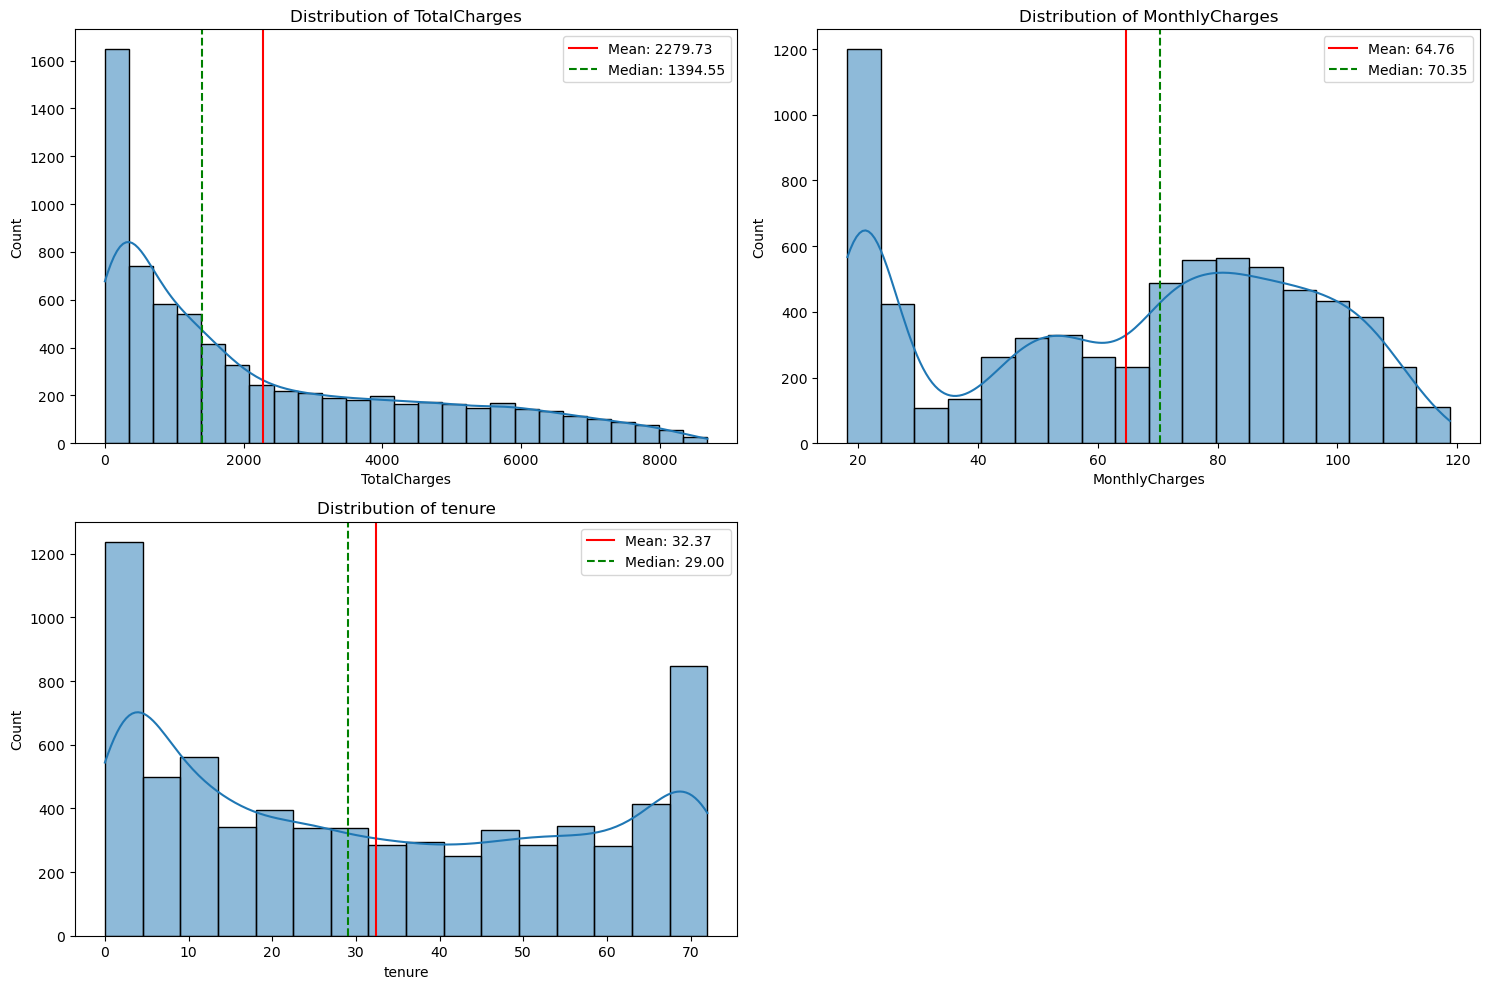

In [23]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot histograms in the first three subplots
plot_hist(df, "TotalCharges", ax=axes[0, 0])
plot_hist(df, "MonthlyCharges", ax=axes[0, 1])
plot_hist(df, "tenure", ax=axes[1, 0])

# Hide the unused subplot (axes[1,1])
fig.delaxes(axes[1, 1])

# Adjust layout
plt.tight_layout()
plt.show()


In [24]:
#create a function for plotting boxplot
def plot_box(df, column_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))  # Create a new figure if no axis is provided
    
    sns.boxplot(y=df[column_name], ax=ax)
    ax.set_title(f"Box Plot of {column_name}")
    ax.set_ylabel(column_name)

    if ax is None:  # Show only if a new figure was created
        plt.show()



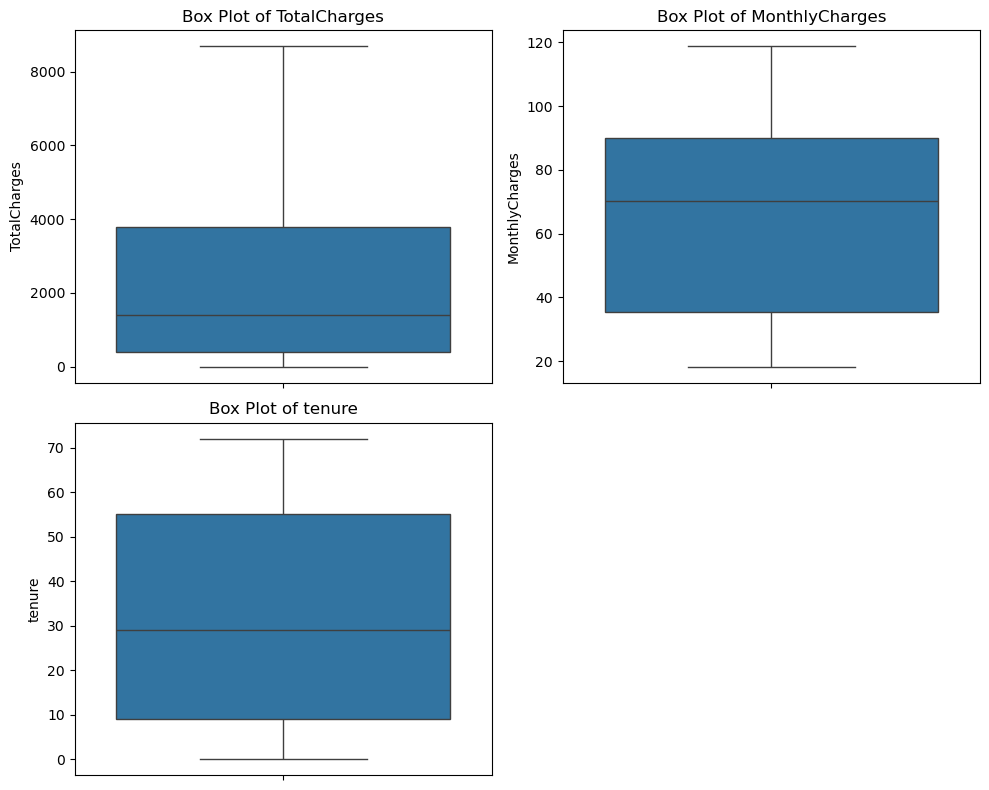

In [25]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms in the first three subplots
plot_box(df, "TotalCharges", ax=axes[0, 0])
plot_box(df, "MonthlyCharges", ax=axes[0, 1])
plot_box(df, "tenure", ax=axes[1, 0])

# Hide the unused subplot (axes[1,1])
fig.delaxes(axes[1, 1])

# Adjust layout
plt.tight_layout()
plt.show()


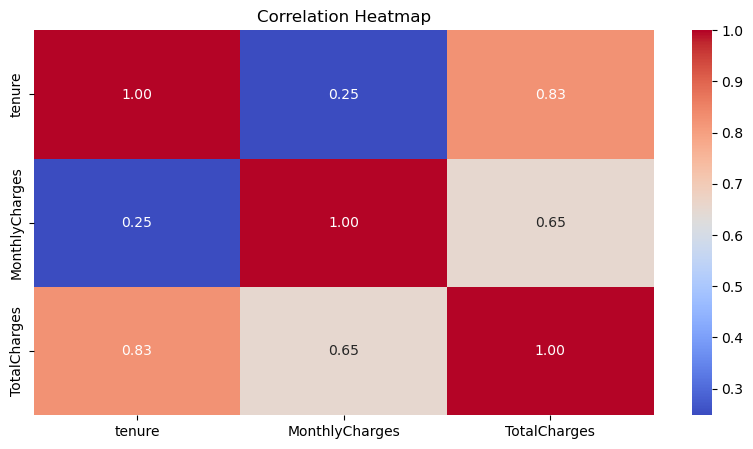

In [28]:
#plot corrlation matrix using heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

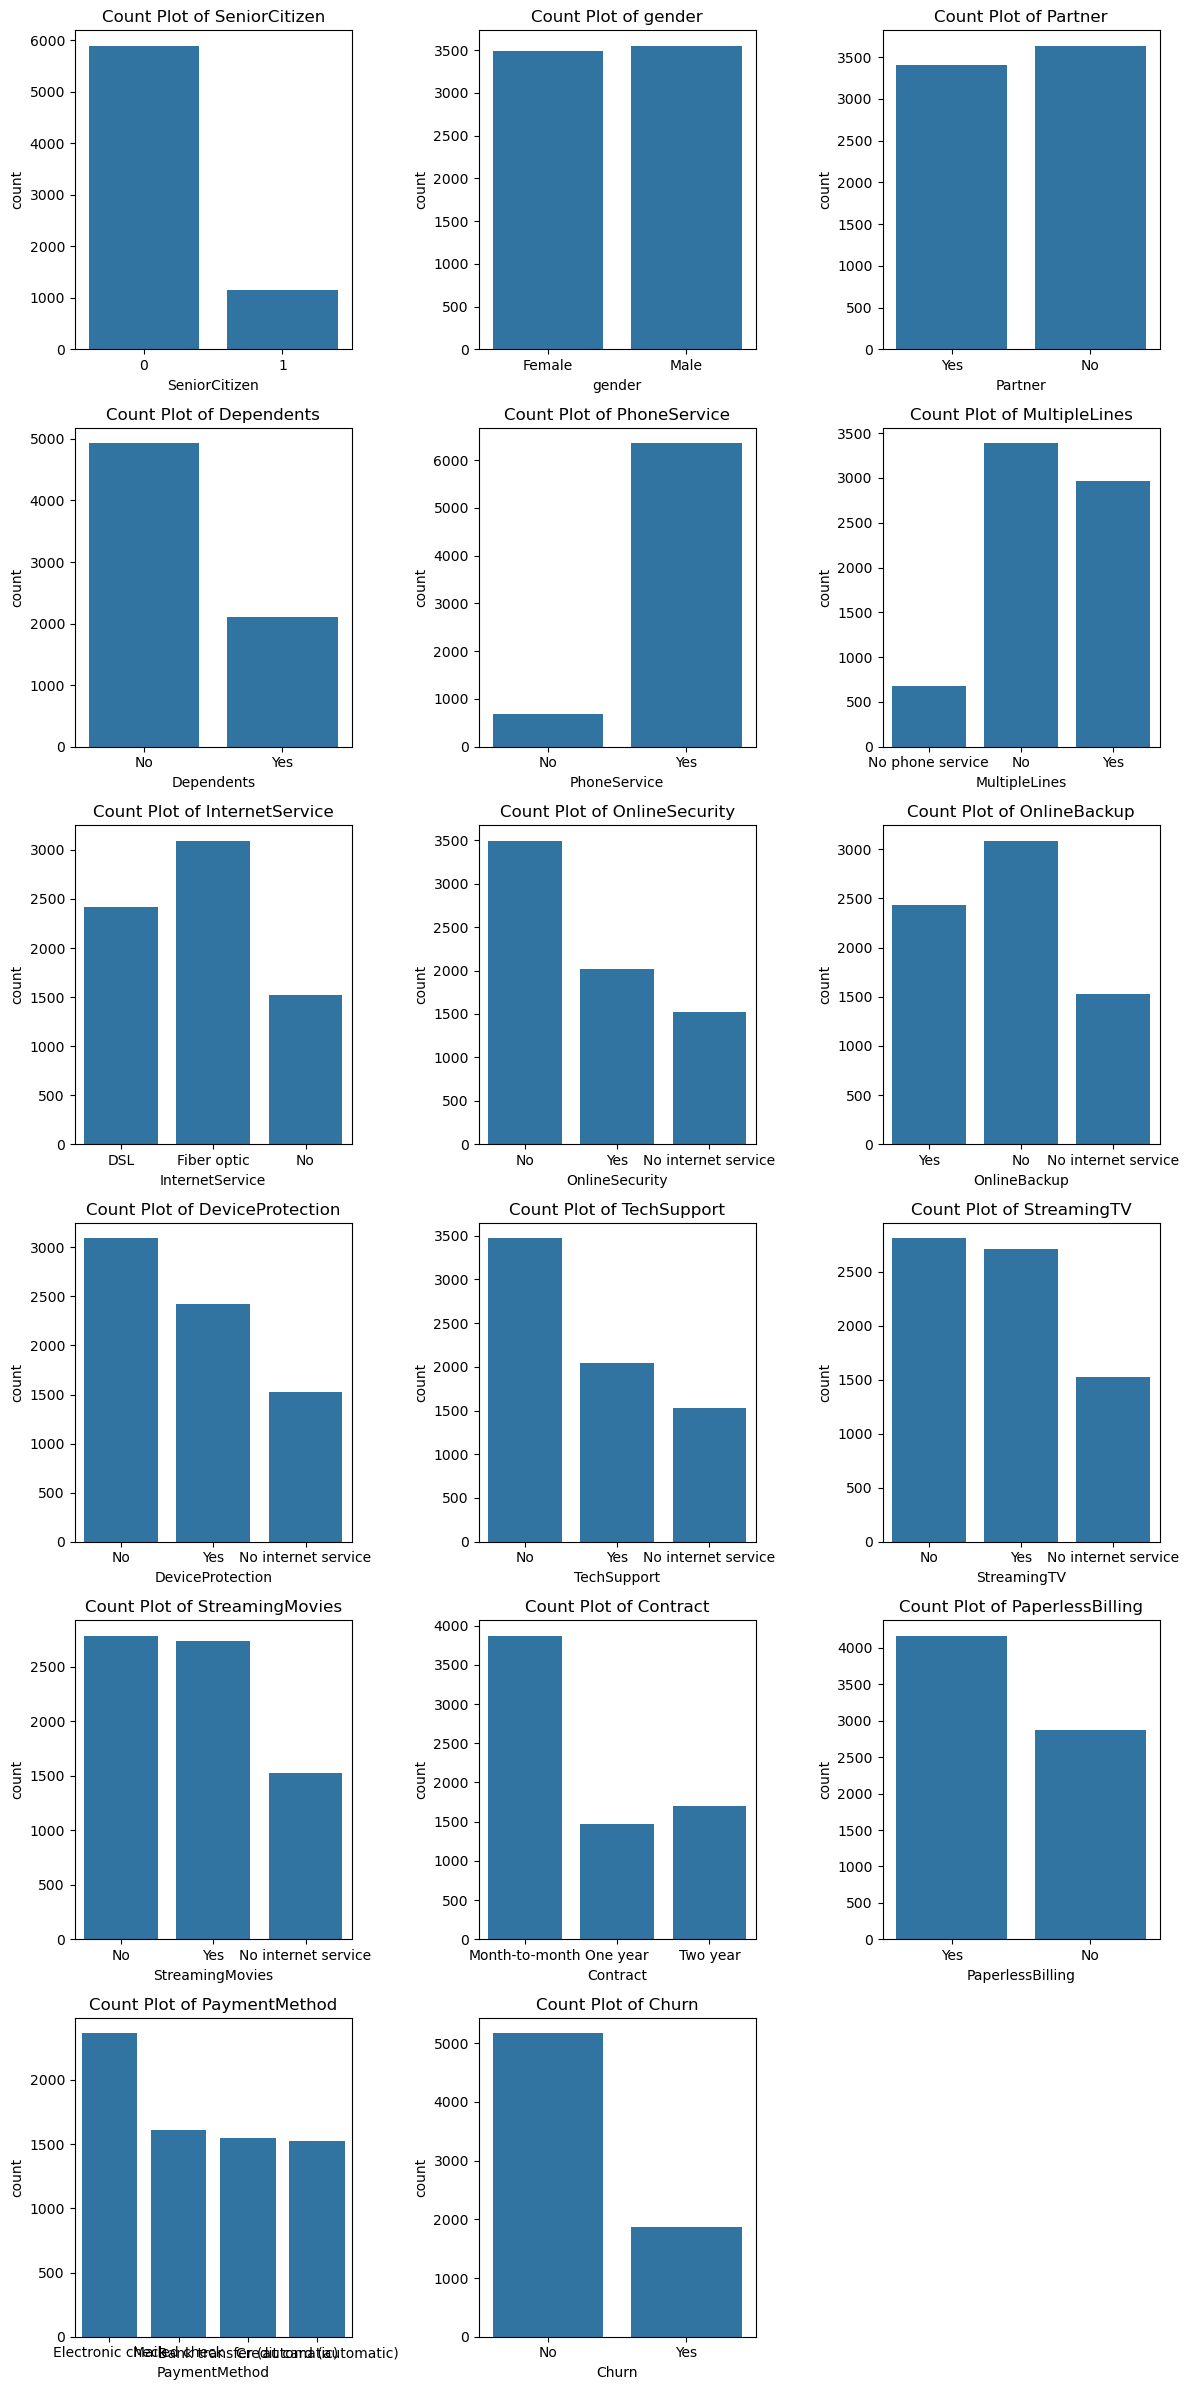

In [31]:
# Convert categorical values to count 
object_cols = df.select_dtypes(include="object").columns.to_list()
object_cols = ["SeniorCitizen"] + object_cols 

cols_per_row = 3
# Create subplots for each pair of categorical columns
num_rows = -(-len(object_cols) // cols_per_row)  # Equivalent to math.ceil
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(12, 4 * num_rows))

# Flatten axes in case we have multiple rows
axes = axes.flatten()

for i, col in enumerate(object_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Count Plot of {col}")

# Hide any unused subplots (if the number of categorical columns is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [32]:
#df["Churn"] = df["Churn"].replace({"Yes":1, "No": 0})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
#indifying columns with object data type
object_cols = df.select_dtypes(include="object").columns
print(object_cols)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [37]:
# Find categorical columns
object_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Categorical columns found:", object_cols)


Categorical columns found: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [39]:
#convert the columns values to numerical values 
#initialize a dictionary to save the encoders
encoders = {}

# Apply label encoding
for column in object_cols:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])  # Transform dataset
    encoders[column] = label_encoder  # Save the encoder

# Save the encoders
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

print("Encoders saved successfully! Encoded columns:", encoders.keys())

Encoders saved successfully! Encoded columns: dict_keys(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'])


In [41]:
# Load the saved encoders
with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

# Print the keys (column names that were encoded)
print("Loaded encoders:", encoders.keys())


Loaded encoders: dict_keys(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'])


In [43]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


**3-Training and Testing the Data**

In [46]:
#spliting the features and target 

x = df.drop(columns=["Churn"])
y = df["Churn"]

In [48]:
#spliting training data and test data 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)


In [50]:
print(y_train.shape)

(5634,)


In [52]:
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


In [54]:
smote = SMOTE(random_state=4)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [56]:
print(y_train_smote.shape)

(8276,)


In [58]:
print(y_train_smote.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


**4-Model Training**

In [61]:
#training with default hayperparameters
#dictionary of models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBRFClassifier(random_state=42)
}


In [63]:
#dictionary for storing the results of cross validation
cv_scores = {}

#preform 5-fold cross validtion for each model
for model_name, model in models.items():
    print(f"Training {model_name} with default parameters")
    scores = cross_val_score(model, x_train_smote, y_train_smote, cv=5, scoring="accuracy")
    cv_scores[model_name] = scores
    print(f"{model_name} cross-validation accuracy: {np.mean(scores):2f}")
    print("-"*50)

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.791335
--------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.841361
--------------------------------------------------
Training XGBoost with default parameters
XGBoost cross-validation accuracy: 0.810546
--------------------------------------------------


**As appear Random forest gives the highest accuracy**

In [65]:
rfc = RandomForestClassifier(random_state=42)

In [66]:
rfc.fit(x_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

**5-Model Evaluation**

In [68]:
#evaluat on test data
y_test_pred = rfc.predict(x_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("-"*60)
print("Confsuion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("-"*60)
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("-"*60)

Accuracy Score:
 0.7778566359119943
------------------------------------------------------------
Confsuion Matrix:
 [[873 163]
 [150 223]]
------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1036
           1       0.58      0.60      0.59       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

------------------------------------------------------------


In [69]:
#saving the trained model as a pickle file
model_data = {"model":rfc, "features_names": x.columns.tolist()}

with open("coustomer_churn_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

**6-Loading the saved model and buold a Predictive System**

In [71]:
#load the saved model and the features

with open("coustomer_churn_model.pkl", "rb") as f:
    model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]

In [88]:
print(loaded_model)

RandomForestClassifier(random_state=42)


In [90]:
print(feature_names)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [92]:
customer_data = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 1,
    "PhoneService": "No",
    "MultipleLines": "No phone service",
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 29.85,
    "TotalCharges": 29.85,
    "Churn": "No"
}

customer_data_df = pd.DataFrame([customer_data])

with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

print(customer_data_df.head())

#encode categorical features using the saved encoders
for column, encoder in encoders.items():
    customer_data_df[column] = encoder.transform(customer_data_df[column])
    

   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   

  PaperlessBilling     PaymentMethod  MonthlyCharges  TotalCharges Churn  
0              Yes  Electronic check           29.85         29.85    No  


In [94]:
customer_data_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0


In [102]:
# Remove the 'Churn' column from customer_data_df 
customer_data_df = customer_data_df.drop(columns=['Churn'], errors='ignore')

# Make a prediction
prediction = loaded_model.predict(customer_data_df)
pred_prob = loaded_model.predict_proba(customer_data_df)

# Convert probabilities to percentages
labels = ['No Churn', 'Churn']
probabilities = [prob * 100 for prob in pred_prob[0]]  # Convert to percentage

print("\nPrediction Result:")
print("--------------------")
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediction Probability (Churn): {probabilities[1]:.1f}%")
print(f"Prediction Probability (No Churn): {probabilities[0]:.1f}%")


Prediction Result:
--------------------
Prediction: No Churn
Prediction Probability (Churn): 22.0%
Prediction Probability (No Churn): 78.0%


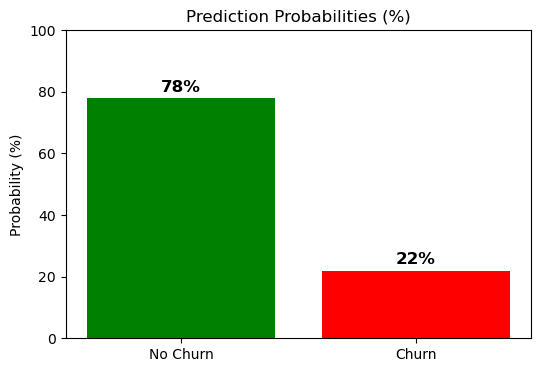

In [104]:
# Create a bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, probabilities, color=['green', 'red'])
plt.title('Prediction Probabilities (%)')
plt.ylabel('Probability (%)')
plt.ylim(0, 100) 

# Adding percentage labels on the bars
for i, v in enumerate(probabilities):
    plt.text(i, v + 2, f"{v:.0f}%", ha='center', fontsize=12, fontweight='bold')

plt.show()